# Lab 2: Methods in Linear Regression

## Problems:

### Problem 1: Bootstrapping a Confidence Interval

If we don't have a formula for the confidence interval of a statistic, we can often estimate it by sampling from out data set many times, computing the statistic of interest, and then plotting the distribution. This is known as __bootstrapping__ the confidence interval, since you're using the data to make estimates about your fits, effectively pulling yourself up by your bootstraps. In this problem, we will see how to boot strap the confidence interval for the $\beta$ parameters in the linear fit. 

__Continue with the Lab2 Master file.__ Lets return to the one variable examples of fitting the sales price to the first floor square footage __1stFlrSF__. Using a for loop, compute $\beta_0$ and $\beta_1$ 1000 times for samples of size $N = 1436$ __with replacement__ and store their results in vectors, as in the code below. 


In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

import io
import urllib.request

# Download the data using urllib
url = "https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Datasets/Ames/train.csv"
response = urllib.request.urlopen(url)
s = response.read().decode('utf-8')

# Load the data into pandas
ames = pd.read_csv(io.StringIO(s))

X = ames['1stFlrSF'].values.reshape(-1, 1)  
y = ames['SalePrice'].values               

N = 1000

beta0 = np.zeros(N)
beta1 = np.zeros(N)

# Bootstrap loop
for i in range(N):
    # Extract bootstrap samples from the original data (with replacement sampling)
    indices = np.random.choice(len(X), size=len(X), replace=True)
    X_sample = X[indices]
    y_sample = y[indices]
    
    # Use sklearn to fit a linear regression model
    model = LinearRegression().fit(X_sample, y_sample)
    
    # Store the values of beta0 and beta1
    beta0[i] = model.intercept_  
    beta1[i] = model.coef_[0]

__Turn in__

1. Plot a histogram of $\beta_0$ and $\beta_1$. 
2. Using `beta0.sort()`, sort the values and find the interval containing the middle 950 values. This is the bootstrap 95% confidence interval. 
3. Using the formulas from (Section 4.Statistics for ML. Sec4StatisticsML.pdf page 17.), compute the confidence interval. Remember that here you use all of the training data. Compare your results. 


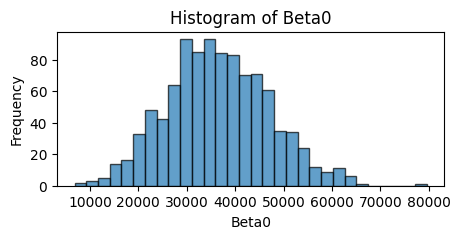

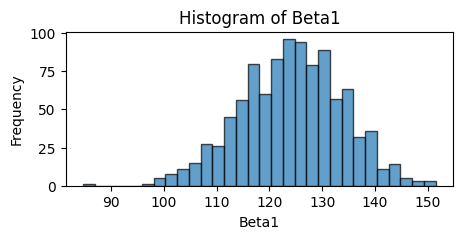

In [25]:
# Plot a histogram of beta0 and beta1.

# Draw histogram of beta0
plt.figure(figsize=(5, 2))
plt.hist(beta0, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Beta0')
plt.xlabel('Beta0')
plt.ylabel('Frequency')
plt.show()

# Draw histogram of beta1
plt.figure(figsize=(5, 2))
plt.hist(beta1, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Beta1')
plt.xlabel('Beta1')
plt.ylabel('Frequency')
plt.show()
    

In [26]:
# Sort beta0 and beta1
beta0_sorted = np.sort(beta0)
beta1_sorted = np.sort(beta1)

lower_idx = int(0.025 * N)  # 2.5th percentile
upper_idx = int(0.975 * N)  # 97.5th percentile

# 95% Confidence Interval
beta0_ci = [beta0_sorted[lower_idx], beta0_sorted[upper_idx]]
beta1_ci = [beta1_sorted[lower_idx], beta1_sorted[upper_idx]]

print(f"Bootstrap 95% Condifence Interval for beta0: {beta0_ci}")
print(f"Bootstrap 95% Confidence Interval for beta1: {beta1_ci}")

Bootstrap 95% Condifence Interval for beta0: [17356.377396488708, 58389.7216721381]
Bootstrap 95% Confidence Interval for beta1: [104.18159235956533, 142.59249886252954]


##### Problem 2: Linear Methods on High Dimensional Data

Perform ridge regression and lasso regression on the MRI Slices dataset on blackboard. You should follow the __Loading the Viewing MRI Slices__ notebook, eventually loading all slices into Python as a data matrix, with all picture dimensions flattened. The text and code for that process has been reproduced below.

We want to fit the MRI Slices data to the __Normalized Whole-brain Volume (nWBV)__ in the labels data.


__Turn in__: 

1. Given the train-test split with seed random_state=$255$, what is the best $\alpha$ value for pure Ridge Regression? Justify your answer. 
2. Given the train-test split with seed random_state=$255$, what is the best $\lambda$ value for pure Lasso Regression? Justify your answer. 
3. (Bonus) What is the best $(\alpha,\lambda)$ value for elastic net regression?

You may set the downsample rate to higher you are unable to compute the linear model.

random_state= 255 will fix the random set. See Wiki for a quick explanation.  https://en.wikipedia.org/wiki/Random_seed
Or https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ for some more details. 

### Load MRI All Files

To load all of the files into an array we need to be able to search through the directory. Luckily, this is easy to do using the labels file, since each file name is stored there. We just need to loop through the __Filename__ column in the `labels` dataset and load them into an array one by one. There are 702 files in total. 

With the array there are two ways we can load them in: First, we can load them into a $609\times 176 \times 176$ array, which is the best option if we care about the 2D structure. However for algorithms like linear regression that can not see the 2D structure, we may want to flatten the images to a $609\times 30976$ array (note that $30976 = 176 \times 176$). Its easy enough two switch back and forth between the two array structures later. We will start with the flattened array. 

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

file_dir = 'C:/Users/29150/Desktop/MRI_Images'

labels = pd.read_csv(file_dir + '/labels.csv')
display(labels)

,Unnamed: 0,Filename,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Slice
0,0,OAS1_0001_MR1_55.png,OAS1_0001_MR1,F,R,74,2,3.0,29,0.0,1344,0.743,1.306,NaN,55
1,1,OAS1_0001_MR1_120.png,OAS1_0001_MR1,F,R,74,2,3.0,29,0.0,1344,0.743,1.306,NaN,120
2,2,OAS1_0001_MR1_180.png,OAS1_0001_MR1,F,R,74,2,3.0,29,0.0,1344,0.743,1.306,NaN,180
3,3,OAS1_0002_MR1_55.png,OAS1_0002_MR1,F,R,55,4,1.0,29,0.0,1147,0.810,1.531,NaN,55
4,4,OAS1_0002_MR1_120.png,OAS1_0002_MR1,F,R,55,4,1.0,29,0.0,1147,0.810,1.531,NaN,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,604,OAS1_0449_MR1_120.png,OAS1_0449_MR1,F,R,71,3,4.0,29,0.0,1264,0.818,1.388,NaN,120
605,605,OAS1_0449_MR1_180.png,OAS1_0449_MR1,F,R,71,3,4.0,29,0.0,1264,0.818,1.388,NaN,180
606,606,OAS1_0456_MR1_55.png,OAS1_0456_MR1,M,R,61,5,2.0,30,0.0,1637,0.780,1.072,NaN,55
607,607,OAS1_0456_MR1_120.png,OAS1_0456_MR1,M,R,61,5,2.0,30,0.0,1637,0.780,1.072,NaN,120


In [28]:
DS = 8             # Downsample rate, must be a multiple of 30976

if 30976/DS % 1 > 0:
    print("Downsample rate is not a multiple of 30976")
    DS = 1
    im_size = 30976
else:
    im_size = int(30976/DS)


data = np.zeros([609, im_size])

for i, file_name in enumerate(labels.Filename):
    img = np.mean(matplotlib.image.imread(file_dir + '/' + file_name),axis=2).reshape(-1)
    data[i,:] = img[::DS]            # Downsample the image

In [29]:
data.shape

(609, 3872)

In [31]:
y = labels['nWBV'].values  
X = data 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=255)

# Ridge regression
ridge = Ridge()
ridge_params = {'alpha': np.logspace(-1, 3, 100)}  
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5)
ridge_grid.fit(X_train, y_train)

print("Best alpha for Ridge:", ridge_grid.best_params_)

# Lasso regression
lasso = Lasso()
lasso_params = {'alpha': np.logspace(-1, 3, 30)} 
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid.fit(X_train, y_train)

print("Best lambda for Lasso:", lasso_grid.best_params_)


Best alpha for Ridge: {'alpha': 3.4304692863149193}
Best lambda for Lasso: {'alpha': 0.1}


In [32]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict Test data results
y_pred_ridge = ridge_grid.predict(X_test)
y_pred_lasso = lasso_grid.predict(X_test)

# Compute MSE and R^2
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred_ridge))
print("Ridge Regression R^2:", r2_score(y_test, y_pred_ridge))

print("Lasso Regression MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Lasso Regression R^2:", r2_score(y_test, y_pred_lasso))


Ridge Regression MSE: 0.00131385454444789
Ridge Regression R^2: 0.394202613310621
Lasso Regression MSE: 0.002272801148575733
Lasso Regression R^2: -0.04795237957667742


The best $\alpha$ value for pure Ridge Regression is appriximately 3.43, and the best $\lambda$ value for pure Lasso Regression is 0.1.